In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

2023-04-30 01:42:00.816441: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 01:42:00.845389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 01:42:00.846117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 01:42:01.382363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from random import shuffle
classes = {"BLE": 0, "Zigbee": 1, "Noise": 2}

# rounds int x to nearest multiple of int y
def roundToNearest(x, y):
    return int((x // y) * y)

class Generator(keras.utils.Sequence):
    def __init__(self, csv_file_path, batch_size, low, high):
        df = pd.read_csv(csv_file_path, header=None)
        # split data
        lowerIdx = roundToNearest(int(len(df)*low), batch_size)
        upperIdx = roundToNearest(int(len(df)*high), batch_size)
        df = df.iloc[lowerIdx:upperIdx]
        # organize data
        data = np.asarray(df.iloc[:, 5:-1], dtype=np.float32)
        samples = len(data[0])
        self.data = data.reshape(-1, 2, samples)
        self.labels = np.asarray(df.iloc[range(0, len(df), 2), 4])
        self.modes = np.asarray(df.iloc[range(0, len(df), 2), 2], dtype=np.int8)
        self.SNRs = np.asarray(df.iloc[range(0, len(df), 2), 1])
        # shuffle data points
        rand_map = list(range(len(self.data)))
        shuffle(rand_map)
        # batch data
        self.data = self.data[rand_map].reshape(-1, batch_size, 2, samples)
        self.labels = self.labels[rand_map].reshape(-1, batch_size)
        self.modes = self.modes[rand_map].reshape(-1, batch_size)
        self.SNRs = self.SNRs[rand_map].reshape(-1, batch_size)
           
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        result = self.data[idx]
        label = [classes[label.strip()] for label in self.labels[idx]]
        return result, label

batch_size = 64
train_gen = Generator("../data/data_iq.csv", batch_size, 0, 0.7)
val_gen = Generator("../data/data_iq.csv", batch_size, 0.7, 0.9)
test_gen = Generator("../data/data_iq.csv", batch_size, 0.9, 1.0)
print(len(train_gen))
print(len(val_gen))
print(len(test_gen))

525
150
75


In [3]:
print(train_gen.data.shape)

(525, 64, 2, 32)


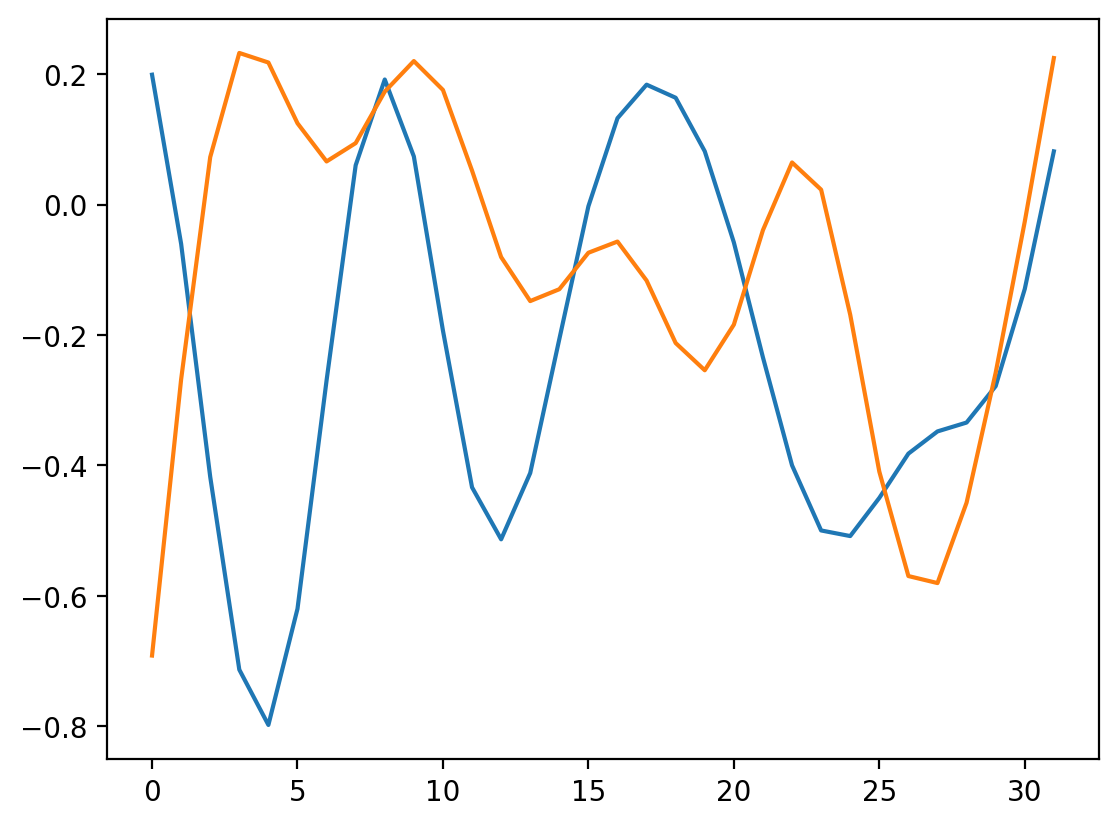

In [4]:
x, y = train_gen[0]
plt.plot(x[0][0])
plt.plot(x[0][1])

In [5]:
def FCN_model():
    inputs = layers.Input(shape=(2, None))
    
    # add channel dimension
    x = tf.expand_dims(inputs, axis=-1)
    
    # conv layers
    x = layers.Conv2D(filters=16, kernel_size=(1, 4), strides=1, padding="same", activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x) # TODO: try different axis?
    
    x = layers.Conv2D(filters=64, kernel_size=(1, 4), strides=1, padding="same", activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(filters=128, kernel_size=(2, 4), strides=1, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    # "fully connected" layers
    x = layers.Conv2D(filters=64, kernel_size=1, strides=1, activation="relu")(x)
    x = layers.Dropout(0.5)(x) # TODO: add batch norm?
    
    x = layers.Conv2D(filters=3, kernel_size=1, strides=1, activation=None)(x)
    pred = layers.GlobalAveragePooling2D()(x) # TODO: add dropout and batch norm?
    
    model = keras.Model(inputs=inputs, outputs=pred)
    print(model.summary())
    return model

model = FCN_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, None)]         0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2, None, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 2, None, 16)       80        
                                                                 
 dropout (Dropout)           (None, 2, None, 16)       0         
                                                                 
 batch_normalization (BatchN  (None, 2, None, 16)      64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, None, 64)       4160      
                                                             

2023-04-30 01:42:09.620405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 01:42:09.817066: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_gen, epochs=10, validation_data=val_gen, validation_steps=len(val_gen))

Epoch 1/10


2023-04-30 01:55:03.791498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


ValueError: in user code:

    File "/home/eminarslan/Developer/CS-342-Neural-Networks/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/eminarslan/Developer/CS-342-Neural-Networks/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/eminarslan/Developer/CS-342-Neural-Networks/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/eminarslan/Developer/CS-342-Neural-Networks/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/eminarslan/Developer/CS-342-Neural-Networks/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/home/eminarslan/Developer/CS-342-Neural-Networks/venv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 279, in __call__
        batch_dim = tf.shape(y_t)[0]

    ValueError: slice index 0 of dimension 0 out of bounds. for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](Shape, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [0], [1], [1], [1] and with computed input tensors: input[1] = <0>, input[2] = <1>, input[3] = <1>.


In [6]:
epochs = 10
criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5)

for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for step, (inputs, labels) in enumerate(train_gen):
        with tf.GradientTape() as tape:
            logits = model(inputs, training=True)
            loss = criterion(labels, logits)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        if not step % 500:
            print(f"Training loss: {float(loss)}")


Start of epoch 0
Training loss: 1.414419412612915
Training loss: 0.8251956105232239

Start of epoch 1
Training loss: 0.7207200527191162
Training loss: 0.7314937114715576

Start of epoch 2
Training loss: 0.7310189008712769
Training loss: 0.7190231680870056

Start of epoch 3
Training loss: 0.6789534091949463
Training loss: 0.7083361744880676

Start of epoch 4
Training loss: 0.7353107929229736
Training loss: 0.6782160401344299

Start of epoch 5
Training loss: 0.716867983341217
Training loss: 0.6606179475784302

Start of epoch 6
Training loss: 0.6923422813415527
Training loss: 0.6726784706115723

Start of epoch 7
Training loss: 0.679427981376648
Training loss: 0.6669270992279053

Start of epoch 8
Training loss: 0.6856671571731567
Training loss: 0.6754216551780701

Start of epoch 9
Training loss: 0.6746021509170532
Training loss: 0.6504418849945068


In [8]:
model2 = model